In [1]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import networkx as nx
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import evaluationData

## BPI 2017 Dataset

In [2]:
df = pd.read_csv("bpi2017_final.csv")
print(df.columns)
df.head()

Index(['case:concept:name', 'NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'treatedCase',
       'caseSuccesful', 'treatmentSuccess', 'offerNumber', 'offerSuccess',
       'treatmentOffer', 'timeApplication', 'weekdayApplication'],
      dtype='object')


,case:concept:name,NumberOfOffers,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,CreditScore,OfferedAmount,treatedCase,caseSuccesful,treatmentSuccess,offerNumber,offerSuccess,treatmentOffer,timeApplication,weekdayApplication
0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,651433.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,2.0
1,0.0,1.0,4.0,0.0,8.0,0.0,1.0,651434.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.061,2.0
2,0.0,1.0,0.0,0.0,22.0,2.0,3.0,651435.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.290,2.0
3,0.0,1.0,1.0,0.0,22.0,2.0,6.0,651437.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.613,2.0
4,0.0,1.0,0.0,0.0,21.0,2.0,3.0,651438.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.620,2.0


In [3]:
#decide on features based on dot_graph
treatment=df['treatmentOffer']
features = df[['NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected',
       'CreditScore', 'OfferedAmount', 'offerNumber','timeApplication', 'weekdayApplication']]
y=df['offerSuccess']

In [4]:
dot_graph = nx.DiGraph ([('treatmentOffer', 'offerSuccess'), ('treatmentOffer', 'timeApplication'), ('NumberOfOffers', 'treatmentOffer'), ('treatmentOffer', 'org:resource'), ('offerNumber', 'treatmentOffer'), ('org:resource', 'OfferedAmount'), ('case:RequestedAmount', 'org:resource'),
                         ('offerNumber', 'timeApplication'), ('NumberOfOffers', 'OfferedAmount'),  ('OfferedAmount', 'MonthlyCost'), ('OfferedAmount', 'FirstWithdrawalAmount'), ('OfferedAmount', 'NumberOfTerms'), ('case:RequestedAmount', 'OfferedAmount'), 
                         ('case:ApplicationType', 'FirstWithdrawalAmount'), ('CreditScore', 'FirstWithdrawalAmount'), ('CreditScore', 'case:ApplicationType'), ('CreditScore', 'offerSuccess'), ('CreditScore', 'Selected'), ('Selected', 'offerSuccess'),
                         ('case:LoanGoal', 'case:RequestedAmount'), ('case:LoanGoal', 'timeApplication'), ('timeApplication', 'case:RequestedAmount'), ('timeApplication', 'NumberOfTerms'), ('NumberOfOffers', 'offerSuccess')])

In [5]:
model = CausalModel(
   data=df, # some pandas dataframe
   treatment='treatmentOffer',
   outcome='offerSuccess',
   graph="\n".join(nx.generate_gml(dot_graph))
)

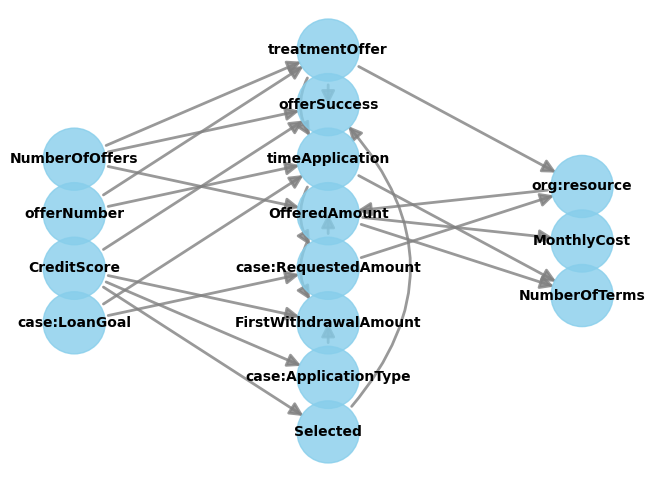

In [6]:
model.view_model()

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                               -1⎤
 ⎢      d                      ⎛      d                         ⎞  ⎥
E⎢──────────────(offerSuccess)⋅⎜──────────────([treatmentOffer])⎟  ⎥
 ⎣d[offerNumber]               ⎝d[offerNumber]                  ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→offerSuccess then ¬(U →→{offerNumber})
Estimand assumption 2, Exclusion: If we remove {offerNumber}→{treatmentOffer}, then ¬({offerNumber}→offerSuccess)

### Estimand : 3
Estimand na

### Regression

In [8]:
# Run a linear regression of column successful on treatment in df
t = df['treatmentOffer'].astype(int)
y = df['offerSuccess'].astype(int)

t = sm.add_constant(t)

ols = sm.OLS(y, t).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4928      0.000   1001.087      0.000       0.492       0.494
treatmentOffer     0.1375      0.001    107.425      0.000       0.135       0.140


In [9]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futu

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers+treatmentOffer*CreditScore+treatmentOffer*Selected
Target units: 

## Estimate
Mean value: 0.4490455740173966
### Conditional Estimates
__categorical__CreditScore  __categorical__Selected
(-0.001, 799.0]             (-0.001, 1.0]              0.219231
(799.0, 923.0]              (-0.001, 1.0]              0.746398
(923.0, 1145.0]             (-0.001, 1.0]              0.843992
dtype: float64


/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


### Double ML

In [7]:
simple_dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(simple_dml_estimate)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers | CreditScore,Selected
Target units: 

## Estimate
Mean value: 0.4711545514760739
Effect estimates: [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.95245462]
 [0.95245462]
 [0.95245462]]



In [8]:
ite_dml = np.reshape(simple_dml_estimate.cate_estimates, -1)
ite_dml

array([0.        , 0.        , 0.        , ..., 0.95245462, 0.95245462,
       0.95245462])

In [13]:
# Calculate statistics
data = ite_dml
minimum = np.min(data)
first_quartile = np.percentile(data, 25)
median = np.median(data)
third_quartile = np.percentile(data, 75)
maximum = np.max(data)

# Interquartile range (IQR)
iqr = third_quartile - first_quartile

# Define upper and lower bounds for outliers
upper_bound = third_quartile + 1.5 * iqr
lower_bound = first_quartile - 1.5 * iqr

# Detect outliers
outliers = data[(data < lower_bound) | (data > upper_bound)]

# Print the statistics
print("Minimum:", minimum)
print("First Quartile:", first_quartile)
print("Median:", median)
print("Third Quartile:", third_quartile)
print("Maximum:", maximum)
print("Interquartile Range:", iqr)
print("Upper Bound (Outliers):", upper_bound)
print("Lower Bound (Outliers):", lower_bound)
print("Outliers:", outliers)

Minimum: 0.0
First Quartile: 0.0
Median: 0.0
Third Quartile: 0.9730893270729309
Maximum: 1.243512588726011
Interquartile Range: 0.9730893270729309
Upper Bound (Outliers): 2.4327233176823273
Lower Bound (Outliers): -1.4596339906093965
Outliers: []


In [27]:
ite_list = [minimum, first_quartile, median, third_quartile, maximum, iqr, upper_bound, lower_bound]
ite_list

In [33]:
%store -r bpi2017_result
dowhy = "DoWhy"
method = "Double ML"
ite = ite_list

if method in bpi2017_result['method'].values:
     # If the method is already in the DataFrame, update the ITE
    index = bpi2017_result[bpi2017_result['method'] == method].index[0]
    bpi2017_result.at[index, 'ITE'] = ite
else:
    # If the method is not in the DataFrame, add a new row
    bpi2017_result = bpi2017_result._append({'method': method, 'ITE': [ite], 'Library': dowhy}, ignore_index=True)
%store bpi2017_result

1
Stored 'bpi2017_result' (DataFrame)


### IPW Weighting

In [11]:
#Vanilla Inverse Propensity Score weighting (IPS)
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: ate

## Estimate
Mean value: 0.3113522997394646

Causal Estimate is 0.3113522997394646


In [12]:
#Self-normalized IPS weighting (also known as the Hajek estimator)
ipw_hajek = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_normalized_weight"})
print(ipw_hajek)
print("IPW Hajek Causal Estimate is " + str(ipw_hajek.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: ate

## Estimate
Mean value: 0.3113522997394638

IPW Hajek Causal Estimate is 0.3113522997394638


In [13]:
#Stabilized IPS weighting
ipw_stabilized = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_stabilized_weight"})
print(ipw_stabilized)
print("IPW Stabilized Causal Estimate is " + str(ipw_stabilized.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: ate

## Estimate
Mean value: 0.3113522997394641

IPW Stabilized Causal Estimate is 0.3113522997394641


### Method: Matching

Propensity Score Matching

In [14]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: ate

## Estimate
Mean value: -0.17928865352214227

Causal Estimate is -0.17928865352214227


Distance Matching: Define a distance metric and then use the metric to match closest points between treatment and control.

In [15]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: att

## Estimate
Mean value: 0.6303219106957425

Causal Estimate is 0.6303219106957425


## Synthetic Dataset

In [2]:
df_synth = pd.read_csv("synthetic_dataset.csv")
df_synth.head()
print(df_synth.columns)
synthetic_features = ['NumberOfOffers', 'concept:name',
       'lifecycle:transition', 'time:timestamp', 'elementId', 'resourceId',
       'weekdayApplication', 'timeApplication']
t=df_synth['treatment']
X = df_synth[synthetic_features]
y=df_synth['treatmentSuccess']

Index(['case:concept:name', 'NumberOfOffers', 'concept:name',
       'lifecycle:transition', 'time:timestamp', 'elementId', 'resourceId',
       'treatment', 'successful', 'treatmentSuccess', 'weekdayApplication',
       'timeApplication'],
      dtype='object')


In [4]:
synth_dot_graph = nx.DiGraph ([ ('treatment', 'treatmentSuccess'), ('NumberOfOffers', 'timeApplication'), ('NumberOfOffers', 'treatmentSuccess')])

In [5]:
synth_model = CausalModel(
   data=df_synth, # some pandas dataframe
   treatment='treatment',
   outcome='treatmentSuccess',
   graph="\n".join(nx.generate_gml(synth_dot_graph))
)

In [6]:
synth_identified_estimand= synth_model.identify_effect(proceed_when_unidentifiable=True)
print(synth_identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[treatmentSuccess])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→treatmentSuccess then P(treatmentSuccess|treatment,,U) = P(treatmentSuccess|treatment,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
synth_linear_estimate = synth_model.estimate_effect(synth_identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(synth_linear_estimate)

synth_simple_dml_estimate = synth_model.estimate_effect(synth_identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(synth_simple_dml_estimate)

synth_ite_dml = np.reshape(synth_simple_dml_estimate.cate_estimates, -1)
synth_ite_dml

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futu

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[treatmentSuccess])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→treatmentSuccess then P(treatmentSuccess|treatment,,U) = P(treatmentSuccess|treatment,)

## Realized estimand
b: treatmentSuccess~treatment+treatment*NumberOfOffers
Target units: 

## Estimate
Mean value: 2.000000000000012
### Conditional Estimates
__categorical__NumberOfOffers
(0.999, 2.0]    2.0
(2.0, 8.0]      2.0
dtype: float64


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
A column-vector y was passed when a 1d array was expected. Please change

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(E[treatmentSuccess])
d[treatment]                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→treatmentSuccess then P(treatmentSuccess|treatment,,U) = P(treatmentSuccess|treatment,)

## Realized estimand
b: treatmentSuccess~treatment | NumberOfOffers
Target units: 

## Estimate
Mean value: 1.9944874764048455
Effect estimates: [[1.99590793]
 [1.99590793]
 [1.99590793]
 ...
 [1.99264085]
 [1.99264085]
 [1.99264085]]



array([1.99590793, 1.99590793, 1.99590793, ..., 1.99264085, 1.99264085,
       1.99264085])

IPW models and Matching models not applicable to synthetic dataset

In [12]:
# Calculate statistics
data = synth_ite_dml
minimum = np.min(data)
first_quartile = np.percentile(data, 25)
median = np.median(data)
third_quartile = np.percentile(data, 75)
maximum = np.max(data)

# Interquartile range (IQR)
iqr = third_quartile - first_quartile

# Define upper and lower bounds for outliers
upper_bound = third_quartile + 1.5 * iqr
lower_bound = first_quartile - 1.5 * iqr

synth_ite_list = [minimum, first_quartile, median, third_quartile, maximum, iqr, upper_bound, lower_bound]
synth_ite_list

In [13]:
%store -r df_synthetic_results
method = "Double ML"
ite = synth_ite_list
ate = synth_ite_dml.mean()

df_synthetic_results = df_synthetic_results._append({'method': method, 'ITE': synth_ite_list, 'ATE': ate}, ignore_index=True)

%store df_synthetic_results

Stored 'df_synthetic_results' (DataFrame)


In [14]:
%store -r df_synthetic_results
method = "Linear Regression"
ate = synth_linear_estimate.value

df_synthetic_results = df_synthetic_results._append({'method': method, 'ATE': ate}, ignore_index=True)

%store df_synthetic_results

Stored 'df_synthetic_results' (DataFrame)


## Evaluation of Methods

Refute the obtained estimate using multiple robustness checks.
- Add random cause
- Add placebo treatment
- Remove Random Subset of Data
- Replace random feature variable

In [16]:
df_new, X_new, y_new, treatment_new, replaced_feature = evaluationData.randomReplace(df)
modelEvaluation = CausalModel(
   data=df_new, # some pandas dataframe
   treatment='treatmentOffer',
   outcome='offerSuccess',
   graph="\n".join(nx.generate_gml(dot_graph))
)
print(replaced_feature)

timeApplication


1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


In [17]:
res_cause_lr=model.refute_estimate(identified_estimand, linear_estimate, method_name="random_common_cause")
print("Refute Estimate for random common cause of Linear Regression: ", res_cause_lr)

res_placebo_lr=model.refute_estimate(identified_estimand, linear_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of Linear Regression: ", res_placebo_lr)

res_subset_lr = model.refute_estimate(
                                    identified_estimand,
                                    linear_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Linear Regression: ",res_subset_lr)

res_replace_lr = modelEvaluation.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print("Refute Estimate for random feature replacement of Linear Regression: ",res_replace_lr)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

Refute Estimate for random common cause of Linear Regression:  Refute: Add a random common cause
Estimated effect:0.4490455740173966
New effect:0.44904573724009944
p value:0.94



The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

Refute Estimate for placebo treatment of Linear Regression:  Refute: Use a Placebo Treatment
Estimated effect:0.4490455740173966
New effect:0.000357254397189255
p value:0.33719875992874027



The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

Refute Estimate for random subset remove of Linear Regression:  Refute: Use a subset of data
Estimated effect:0.4490455740173966
New effect:0.4490789643513969
p value:0.9199999999999999



The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Refute Estimate for random feature replacement of Linear Regression:  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers+treatmentOffer*CreditScore
Target units: 

## Estimate
Mean value: 0.44979658104480896
### Conditional Estimates
__categorical__CreditScore
(-0.001, 799.0]    0.225529
(799.0, 923.0]     0.746064
(923.0, 1145.0]    0.829024
dtype: float64


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [ ]:
#SKIP
#does not give results in an appropriate time
# res_cause_dml=model.refute_estimate(identified_estimand, simple_dml_estimate, method_name="random_common_cause")
# print("Refute Estimate for random common cause of Simple DML: ", res_cause_dml)
res_cause_dml = 0

res_placebo_dml=model.refute_estimate(identified_estimand, simple_dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of Simple DML: ", res_placebo_dml)

res_subset_dml = model.refute_estimate(
                                    identified_estimand,
                                    simple_dml_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Simple DML: ",res_subset_dml)

res_replace_dml = modelEvaluation.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print("Refute Estimate for random feature replacement of Simple DML: ",res_replace_dml)

In [18]:
res_cause_ipw=model.refute_estimate(identified_estimand, causal_estimate_ipw, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW: ", res_cause_ipw)

res_placebo_ipw=model.refute_estimate(identified_estimand, causal_estimate_ipw,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of IPW: ", res_placebo_ipw)

res_subset_ipw = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_ipw,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW: ",res_subset_ipw)

res_replace_ipw = modelEvaluation.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print("Refute Estimate for random feature replacement of IPW: ",res_replace_ipw)

Refute Estimate for random common cause of IPW:  Refute: Add a random common cause
Estimated effect:0.3113522997394646
New effect:0.3113522997394646
p value:1.0

Refute Estimate for placebo treatment of IPW:  Refute: Use a Placebo Treatment
Estimated effect:0.3113522997394646
New effect:0.1905922560633438
p value:0.0

Refute Estimate for random subset remove of IPW:  Refute: Use a subset of data
Estimated effect:0.3113522997394646
New effect:0.31143627778185656
p value:0.74



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


Refute Estimate for random feature replacement of IPW:  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,NumberOfOffers,U) = P(offerSuccess|treatmentOffer,NumberOfOffers)

## Realized estimand
b: offerSuccess~treatmentOffer+NumberOfOffers
Target units: ate

## Estimate
Mean value: 0.3113522997394646



In [19]:
res_cause_ipw_hajek=model.refute_estimate(identified_estimand, ipw_hajek, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW Hajek: ", res_cause_ipw_hajek)

res_placebo_ipw_hajek=model.refute_estimate(identified_estimand, ipw_hajek,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of IPW Hajek: ", res_placebo_ipw_hajek)

res_subset_ipw_hajek = model.refute_estimate(
                                    identified_estimand,
                                    ipw_hajek,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW Hajek: ",res_subset_ipw_hajek)

res_replace_ipw_hajek = modelEvaluation.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_normalized_weight"})
print("Refute Estimate for random feature replacement of IPW Hajek: ",res_replace_ipw_hajek)

Refute Estimate for random common cause of IPW Hajek:  Refute: Add a random common cause
Estimated effect:0.3113522997394638
New effect:0.3113522997394638
p value:1.0

Refute Estimate for placebo treatment of IPW Hajek:  Refute: Use a Placebo Treatment
Estimated effect:0.3113522997394638
New effect:0.18964047331526523
p value:0.0

Refute Estimate for random subset remove of IPW Hajek:  Refute: Use a subset of data
Estimated effect:0.3113522997394638
New effect:0.3114352891702853
p value:0.8600000000000001

Refute Estimate for random feature replacement of IPW Hajek:  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,Nu

In [21]:
res_cause_ipw_stabilized=model.refute_estimate(identified_estimand, ipw_stabilized, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW Stabilized: ", res_cause_ipw_stabilized)

res_placebo_ipw_stabilized=model.refute_estimate(identified_estimand, ipw_stabilized,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of IPW Stabilized: ", res_placebo_ipw_stabilized)

res_subset_ipw_stabilized = model.refute_estimate(
                                    identified_estimand,
                                    ipw_stabilized,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW Stabilized: ",res_subset_ipw_stabilized)

res_replace_ipw_stabilized = modelEvaluation.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_stabilized_weight"})
print("Refute Estimate for random feature replacement of IPW Stabalized: ",res_replace_ipw_stabilized)

Refute Estimate for random common cause of IPW Stabilized:  Refute: Add a random common cause
Estimated effect:0.3113522997394641
New effect:0.3113522997394642
p value:1.0

Refute Estimate for placebo treatment of IPW Stabilized:  Refute: Use a Placebo Treatment
Estimated effect:0.3113522997394641
New effect:0.190683135830597
p value:0.0

Refute Estimate for random subset remove of IPW Stabilized:  Refute: Use a subset of data
Estimated effect:0.3113522997394641
New effect:0.311367503932687
p value:0.96

Refute Estimate for random feature replacement of IPW Stabalized:  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                        
─────────────────(E[offerSuccess|NumberOfOffers])
d[treatmentOffer]                                
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer

In [ ]:
res_cause_match=model.refute_estimate(identified_estimand, causal_estimate_match, method_name="random_common_cause")
print("Refute Estimate for random common cause of Propensity Score Matching: ", res_cause_match)

res_placebo_match=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of Propensity Score Matching: ", res_placebo_match)

res_subset_match = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_match,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Propensity Score Matching: ",res_subset_match)

res_replace_match = modelEvaluation.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print("Refute Estimate for random feature replacement of Propensity Score Matching: ",res_replace_match)

In [ ]:
res_cause_dmatch=model.refute_estimate(identified_estimand, causal_estimate_dmatch, method_name="random_common_cause")
print("Refute Estimate for random common cause of Distance Matching: ", res_cause_dmatch)

res_placebo_dmatch=model.refute_estimate(identified_estimand, causal_estimate_dmatch,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=5)
print("Refute Estimate for placebo treatment of Distance Matching: ", res_placebo_dmatch)

res_subset_dmatch = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_dmatch,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Distance Matching: ",res_subset_dmatch)

res_replace_dmatch = modelEvaluation.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print("Refute Estimate for random feature replacement of Distance Matching: ",res_replace_dmatch)

In [ ]:
res_replace_dml = 0
res_subset_dml = 0
res_placebo_dml = 0
res_cause_dml = 0

In [ ]:
eval_result_list = {'Method': ['Linear Regression', 'Double ML', 'IPW', 'IPW Hajek', 'IPW Stabalized', 'Propensity Score Matching', 'Distance Matching'],
                    'Random Common Cause ATE': [res_cause_lr.new_effect, res_cause_dml.new_effect, res_cause_ipw.new_effect, res_cause_ipw_hajek.new_effect,
                                                res_cause_ipw_stabilized.new_effect, res_cause_match.new_effect, res_cause_dmatch.new_effect],
                    'Placebo treatment ATE': [res_placebo_lr.new_effect, res_placebo_dml.new_effect, res_placebo_ipw.new_effect, res_placebo_ipw_hajek.new_effect,
                                              res_placebo_ipw_stabilized.new_effect, res_placebo_match.new_effect, res_placebo_dmatch.new_effect],                    
                    'Random Subset ATE': [res_subset_lr.new_effect, res_subset_dml.new_effect, res_subset_ipw.new_effect, res_subset_ipw_hajek.new_effect,
                                          res_subset_ipw_stabilized.new_effect, res_subset_match.new_effect, res_subset_dmatch.new_effect],                    
                    'Random Feature Replacement ATE': [res_replace_lr.value,res_replace_dml.value, res_replace_ipw.value, res_replace_ipw_hajek.value,
                                                    res_replace_ipw_stabilized.value, res_replace_match.value, res_replace_dmatch.value]}

In [ ]:
%store -r df_evaluation_results

for i in range(len(eval_result_list['Method'])):
    method = eval_result_list['Method'][i]
    cause = eval_result_list['Random Common Cause ATE'][i]
    placebo = eval_result_list['Placebo treatment ATE'][i]
    subset = eval_result_list['Random Subset ATE'][i]
    replace = eval_result_list['Random Feature Replacement ATE'][i]

    if method in df_evaluation_results['method'].values:
         # If the method is already in the DataFrame, update the ATE and ITE columns
        df_evaluation_results.loc[df_evaluation_results['method'] == method, 'Random Common Cause ATE'] = cause
        df_evaluation_results.loc[df_evaluation_results['method'] == method, 'Placebo treatment ATE'] = placebo
        df_evaluation_results.loc[df_evaluation_results['method'] == method, 'Random Subset ATE'] = subset
        df_evaluation_results.loc[df_evaluation_results['method'] == method, 'Random Feature Replacement ATE'] = replace
        df_evaluation_results.loc[df_evaluation_results['method'] == method, 'Replaced Feature'] = replaced_feature
    else:
        # If the method is not in the DataFrame, add a new row
        df_evaluation_results = df_evaluation_results._append({'method': method, 'Random Common Cause ATE': cause, 'Placebo treatment ATE': placebo, 'Random Subset ATE': subset, 'Random Feature Replacement ATE': replace, 'Replaced Feature': replaced_feature}, ignore_index=True)

df_evaluation_results

In [ ]:
#add evaluation to eval df
%store df_evaluation_results

### Add results to Result-Dataframe

In [40]:
result_list = {'Method': ['Linear Regression', 'Double ML', 'IPW', 'IPW Hajek', 'IPW Stabalized', 'Propensity Score Matching', 'Distance Matching'],
        'ATE': [linear_estimate.value, simple_dml_estimate.value, causal_estimate_ipw.value, ipw_hajek.value, ipw_stabilized.value, 
                causal_estimate_match.value, causal_estimate_dmatch.value],
        'ITE': ['', np.reshape(simple_dml_estimate.cate_estimates, -1), '', '', '', '', '']}

In [43]:
%store -r df_results
dowhy = "DoWhy"

for i in range(len(result_list['Method'])):
    method = result_list['Method'][i]
    ate = result_list['ATE'][i]
    ite = result_list['ITE'][i]

    if method in df_results['method'].values:
         # If the method is already in the DataFrame, update the ATE and ITE columns
        df_results.loc[df_results['method'] == method, 'ATE'] = ate
        df_results.loc[df_results['method'] == method, 'ITE'] = [ite]
        df_results.loc[df_results['method'] == method, 'Library'] = dowhy
    else:
        # If the method is not in the DataFrame, add a new row
        df_results = df_results._append({'method': method, 'ATE': ate, 'ITE': ite, 'Library': dowhy}, ignore_index=True)

print(df_results)
%store df_results

                      method       ATE  \
0          Linear Regression  0.449046   
1                        IPW  0.311352   
2                  IPW Hajek  0.311352   
3             IPW Stabalized  0.311352   
4  Propensity Score Matching -0.179289   
5          Distance Matching  0.630322   
6                     IPW LR  0.149171   
7                  Double ML  0.471019   

                                                 ITE    Library  other  
0                                                         DoWhy    NaN  
1                                                         DoWhy    NaN  
2                                                         DoWhy    NaN  
3                                                         DoWhy    NaN  
4                                                         DoWhy    NaN  
5                                                         DoWhy    NaN  
6                                                     Causallib    NaN  
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
evaluation_list = {'Method': [], 
                   'Placebo': [],
                   'Common Cause': [],
                   'Random Subset': [],
                   'Random Replacement': []}